In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.optimize as op
import numpy as np
from scipy.optimize import least_squares
from matplotlib import rcParams
from matplotlib.colors import LogNorm                
rcParams['font.family'] = 'serif'

%matplotlib inline

In [8]:
def error(params, points): #funcion a minimizar
    A,B,C = params
    A,B,C = np.array([A,B,C])/np.linalg.norm([A,B,C])
    dist = dist_point_plane(A,B,C,0,points)
    return np.sum(dist)

def dist_point_plane(a,b,c,d,point):
    x,y,z = point[:,0],point[:,1],point[:,2]
    dist = np.abs(a*x+b*y+c*z+d)/np.linalg.norm([a,b,c])
    return dist

def plane_fit(points):
    x0 = [.5,.5,.5]
    lo = [-1,-1,-1]
    hi = [1,1,1]
    #Realiza minimos cuadrados a la funcion error con argumentos los puntos
    result = least_squares(error, x0, args=(points,),bounds=(lo, hi),jac='3-point') 
    A,B,C = result['x']
    return A,B,C

In [52]:
def RANSAC(set_points,min_points,number_iterations,threshold,near_points):
    succes = False
    while succes == False:
        iterations = 0
        error_fit = []
        while iterations < number_iterations:
            sample_in = np.array([np.random.randint(len(set_points))]) 
            points_in = set_points[sample_in] 
            loc_dist = np.sqrt((points_in[0,0]-set_points[:,0])**2 +\
                             (points_in[0,1]-set_points[:,1])**2 +\
                             (points_in[0,2]-set_points[:,2])**2)
            sample_out = np.array([i for i in range(len(set_points))])
            sample_out = sample_out[np.where(sample_out != sample_in[0])]
            
            for n in range(min_points):
                loc_dist[sample_in[n]] = np.inf
                sample_in = np.concatenate((sample_in,np.where(loc_dist==np.min(loc_dist))[0]))
                points_in = np.concatenate((points_in,[set_points[sample_in[n+1]]]))
                sample_out = sample_out[np.where(sample_out != sample_in[n+1])]
                
            A,B,C = plane_fit(points_in)
            points_news = points_in
            
            for element in sample_out:
                dist = np.abs(A*set_points[element,0] + \
                             B*set_points[element,1] + \
                             C*set_points[element,2])/np.linalg.norm([A,B,C])
                if dist < threshold:
                    points_news = np.concatenate((points_news,[set_points[element]]))
                    sample_in = np.concatenate((sample_in,[element]))
            
            if len(points_news) > near_points:
                A_new, B_new, C_new = plane_fit(points_news)
                dist = np.abs(A_new*points_news[:,0] + \
                             B_new*points_news[:,1] + \
                             C_new*points_news[:,2])/np.linalg.norm([A_new,B_new,C_new])
                error_fit.append(np.sum(dist))
            else:
                error_fit.append(np.inf)
                
            if error_fit[iterations] <= np.min(np.array(error_fit)):
                points_in = set_points[sample_in]
                points_out = set_points[sample_out]
                norm_best = [A_new,B_new,C_new]
                error_best = error_fit[iterations]
                succes= True
            
            iterations += 1
                
    return points_in, points_out, norm_best, error_best

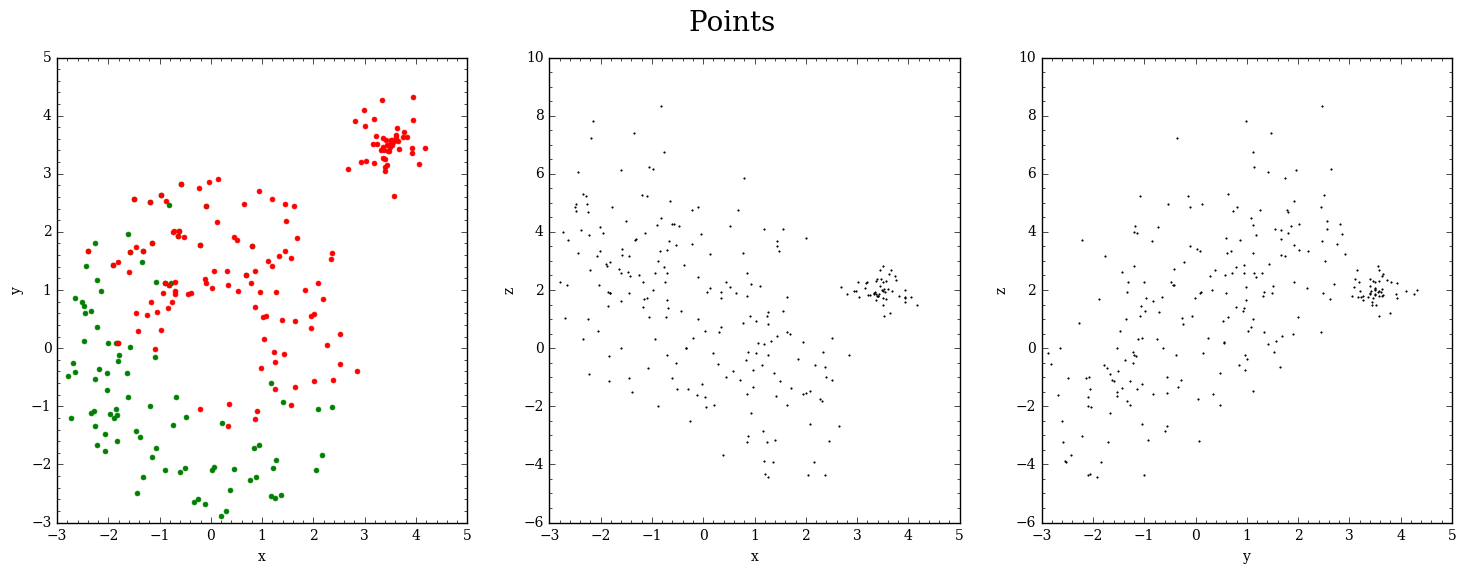

In [53]:
Np = 200
A_true, B_true, C_true = 1, -1, 1
A_true, B_true, C_true = np.array([A_true, B_true, C_true])/np.linalg.norm([A_true, B_true, C_true])


rand_theta = 2*np.pi*np.random.random_sample(Np)
rand_R = 1+2*np.random.random_sample(Np)

x,y = rand_R*np.cos(2*np.pi*rand_theta), rand_R*np.sin(2*np.pi*rand_theta)

z = -A_true/C_true * x - B_true/C_true * y

z += (2*np.random.random_sample(Np)-0.5)*np.random.random_sample(Np)*4

rand_theta = np.pi*np.random.random_sample(Np/4) 
rand_phi = 2*np.pi*np.random.random_sample(Np/4)
rand_R = np.random.random_sample(Np/4)

outliners_x = rand_R*np.sin(rand_theta)*np.cos(rand_phi) + 3.5
outliners_y = rand_R*np.sin(rand_theta)*np.sin(rand_phi) + 3.5
outliners_z = rand_R*np.cos(rand_theta) + 2

x = np.concatenate((x,outliners_x))
y = np.concatenate((y,outliners_y))
z = np.concatenate((z,outliners_z))
points = np.stack([x,y,z],axis=1)

points_in, points_out, _,_ = RANSAC(points,150,50,1,3)

fig, ax = plt.subplots(ncols=3, nrows=1,figsize=[6*3, 6])
fig.suptitle('Points', fontsize=20)
# ax01= ax[0].hist2d(points[:,0],points[:,1], bins=80,norm=LogNorm())
ax[0].plot(points_out[:,0],points_out[:,1],'g.',ms=7,alpha=2)
ax[0].plot(points_in[:,0],points_in[:,1],'r.',ms=7,alpha=2)

ax[0].set(xlabel='x', ylabel='y')
ax[0].minorticks_on()

# ax02= ax[1].hist2d(points[:,0],points[:,2], bins=80,norm=LogNorm())
ax[1].plot(points[:,0],points[:,2],'k.',ms=2,alpha=2)
ax[1].set(xlabel='x', ylabel='z')#,xlim=(-3,3),ylim=(-8,8))
ax[1].minorticks_on()


# ax03= ax[2].hist2d(points[:,1],points[:,2], bins=80,norm=LogNorm())
ax[2].set(xlabel='y', ylabel='z')
ax[2].plot(points[:,1],points[:,2],'k.',ms=2)
ax[2].minorticks_on()